In [1]:
from os import makedirs
from typing import Final, TypeAlias

import nltk
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import inaugural
from pandas import DataFrame

from authorship_tool.types import TwoDimStr, Tag
from authorship_tool.util import dim_reshaper, type_guard
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.lgbm import trainer as lgbm_trainer
from authorship_tool.util.lgbm.model import LGBMResultModel, LGBMSourceModel
from authorship_tool.util.path_util import PathUtil

nltk.download("inaugural")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

Project root: /workspaces/shap-authorship-analysis-demo
Path: path_dump_lgbm_model_dir = /workspaces/shap-authorship-analysis-demo/dump/lgbm/model
Path: path_dump_dataset_dir = /workspaces/shap-authorship-analysis-demo/dump/dataset
Path: path_dump_shap_figure_dir = /workspaces/shap-authorship-analysis-demo/dump/shap/figure
Path: path_adjective_past_participle_dataset = /workspaces/shap-authorship-analysis-demo/data/nlp_datasets/wordLists/adjectivesPastParticiple


[nltk_data] Downloading package inaugural to /home/vscode/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
PRESIDENT_A = "Bush"
PRESIDENT_B = "Obama"


In [3]:
for idx, file_id in enumerate(inaugural.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	1789-Washington.txt
#2	1793-Washington.txt
#3	1797-Adams.txt
#4	1801-Jefferson.txt
#5	1805-Jefferson.txt
#6	1809-Madison.txt
#7	1813-Madison.txt
#8	1817-Monroe.txt
#9	1821-Monroe.txt
#10	1825-Adams.txt
#11	1829-Jackson.txt
#12	1833-Jackson.txt
#13	1837-VanBuren.txt
#14	1841-Harrison.txt
#15	1845-Polk.txt
#16	1849-Taylor.txt
#17	1853-Pierce.txt
#18	1857-Buchanan.txt
#19	1861-Lincoln.txt
#20	1865-Lincoln.txt
#21	1869-Grant.txt
#22	1873-Grant.txt
#23	1877-Hayes.txt
#24	1881-Garfield.txt
#25	1885-Cleveland.txt
#26	1889-Harrison.txt
#27	1893-Cleveland.txt
#28	1897-McKinley.txt
#29	1901-McKinley.txt
#30	1905-Roosevelt.txt
#31	1909-Taft.txt
#32	1913-Wilson.txt
#33	1917-Wilson.txt
#34	1921-Harding.txt
#35	1925-Coolidge.txt
#36	1929-Hoover.txt
#37	1933-Roosevelt.txt
#38	1937-Roosevelt.txt
#39	1941-Roosevelt.txt
#40	1945-Roosevelt.txt
#41	1949-Truman.txt
#42	1953-Eisenhower.txt
#43	1957-Eisenhower.txt
#44	1961-Kennedy.txt
#45	1965-Johnson.txt
#46	1969-Nixon.txt
#47	1973-Nixon.txt
#48	1977-Car

In [4]:
President: TypeAlias = str
NumOfParas: TypeAlias = int

presidents: set[President] = {file_id[5:-4] for file_id in inaugural.fileids()}

president_data_dict: dict[President, NumOfParas] = {}

for index, president in enumerate(iterable=presidents):
    speeches: list[list[TwoDimStr]] = [
        # inaugural.sents(file_id)
        inaugural.paras(fileids=file_id)
        for file_id in inaugural.fileids()
        if president in file_id
    ]  # type: ignore

    para_num: NumOfParas = len([para for paras in speeches for para in paras])
    president_data_dict[president] = para_num

sorted_para_size_by_president: dict[President, NumOfParas] = dict(
    sorted(president_data_dict.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_president.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	Nixon - 128 paragraphs
2:	Roosevelt - 121 paragraphs
3:	Eisenhower - 92 paragraphs
4:	Reagan - 81 paragraphs
5:	Bush - 79 paragraphs
6:	Truman - 71 paragraphs
7:	Obama - 66 paragraphs
8:	Harrison - 60 paragraphs
9:	Clinton - 50 paragraphs
10:	Monroe - 48 paragraphs
11:	Cleveland - 44 paragraphs
12:	Lincoln - 43 paragraphs
13:	Taft - 43 paragraphs
14:	Biden - 41 paragraphs
15:	Garfield - 39 paragraphs
16:	Harding - 34 paragraphs
17:	Hoover - 33 paragraphs
18:	Trump - 32 paragraphs
19:	Grant - 32 paragraphs
20:	Polk - 30 paragraphs
21:	Johnson - 30 paragraphs
22:	McKinley - 30 paragraphs
23:	Wilson - 28 paragraphs
24:	Hayes - 27 paragraphs
25:	Kennedy - 27 paragraphs
26:	Carter - 25 paragraphs
27:	Adams - 24 paragraphs
28:	Coolidge - 24 paragraphs
29:	Jefferson - 22 paragraphs
30:	Jackson - 21 paragraphs
31:	Buchanan - 20 paragraphs
32:	VanBuren - 19 paragraphs
33:	Madison - 18 paragraphs
34:	Pierce - 14 paragraphs
35:	Taylor - 10 paragraphs
36:	Washington - 9 paragraphs


In [5]:
speeches_a: list[list[TwoDimStr]] = [
    inaugural.paras(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_A in file_id
]  # type: ignore

paras_a: list[TwoDimStr] = [para for paras in speeches_a for para in paras]
if len(paras_a) == 0 or not type_guard.are_paras(paras_a):
    raise ValueError("paras_a is empty or not list[Para]")

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_A}, {len(paras_a)} paragraphs\n")

Mr . Chief Justice , Mr . President , Vice President Quayle , Senator Mitchell , Speaker Wright , Senator Dole , Congressman Michael , and fellow citizens , neighbors , and friends :
There is a man here who has earned a lasting place in our hearts and in our history . President Reagan , on behalf of our Nation , I thank you for the wonderful things that you have done for America .
I have just repeated word for word the oath taken by George Washington 200 years ago , and the Bible on which I placed my hand is the Bible on which he placed his . It is right that the memory of Washington be with us today , not only because this is our Bicentennial Inauguration , but because Washington remains the Father of our Country . And he would , I think , be gladdened by this day ; for today is the concrete expression of a stunning fact : our continuity these 200 years since our government began .
We meet on democracy ' s front porch , a good place to talk as neighbors and as friends . For this is a 

In [6]:
speeches_b: list[list[TwoDimStr]] = [
    inaugural.paras(file_id)
    for file_id in inaugural.fileids()
    if PRESIDENT_B in file_id
]  # type: ignore

paras_b: list[TwoDimStr] = [para for paras in speeches_b for para in paras]
for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nSpeaker: President {PRESIDENT_B}, {len(paras_b)} paragraphs\n")

My fellow citizens :
I stand here today humbled by the task before us , grateful for the trust you have bestowed , mindful of the sacrifices borne by our ancestors . I thank President Bush for his service to our nation , as well as the generosity and cooperation he has shown throughout this transition .
Forty - four Americans have now taken the presidential oath . The words have been spoken during rising tides of prosperity and the still waters of peace . Yet , every so often the oath is taken amidst gathering clouds and raging storms . At these moments , America has carried on not simply because of the skill or vision of those in high office , but because We the People have remained faithful to the ideals of our forbearers , and true to our founding documents .
So it has been . So it must be with this generation of Americans .
That we are in the midst of crisis is now well understood . Our nation is at war , against a far - reaching network of violence and hatred . Our economy is badl

In [7]:
print(f"total: {len(paras_a + paras_b)} samples (paragraphs)")

total: 145 samples (paragraphs)


In [8]:
if not (type_guard.are_paras(paras_a) and type_guard.are_paras(paras_b)):
    raise ValueError("paras_a or sents_b is not list[Para]")
all_paras: list[TwoDimStr] = paras_a + paras_b

pos_list: list[Tag] = PosFeature(all_paras).tag_subcategories().pos_list

print(pos_list)

["''", ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [9]:
dataset_generator = ParagraphFeatureDatasetGenerator(pos_list)
data: list[tuple[float, ...]] = []
correctness: list[bool] = []

for para in paras_a:
    x, y = dataset_generator.generate_from_paragraph(para, True)
    data.append(x)
    correctness.append(y)

for para in paras_b:
    x, y = dataset_generator.generate_from_paragraph(para, False)
    data.append(x)
    correctness.append(y)

In [10]:
df = pd.DataFrame(data, columns=dataset_generator.columns)
nd_correctness = np.array(correctness)

pd.set_option("display.max_columns", 1000)
display(df.head(10))
pd.reset_option("display.max_columns")


,UoK v1 sentences per paragraph,UoK v2 words per paragraph,UoK v3 close parenthesis present,UoK v4 dash present,UoK v5 semi-colon or colon present,UoK v6 question mark present,UoK v7 apostrophe present,UoK v8 standard deviation of sentence length,UoK v9 length difference for consecutive sentences,UoK v10 sentence with < 11 words,UoK v11 sentence with > 34 words,UoK v12 contains although,UoK v13 contains however,UoK v14 contains but,UoK v15 contains because,UoK v16 contains this,UoK v17 contains others or researchers,UoK v18 contains numbers,UoK v19 contains 2 times more capitals than period,UoK v20 contains et,word variation,average token length,non alphabetic characters frequency,uncommon word frequency,'',",",.,:,CC,CD,DT,EX,IN,JJ,JJR,JJS,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,1,34,False,False,True,False,False,0.000000,0.000000,False,False,False,False,False,False,False,False,False,True,False,0.617647,4.382353,0.352941,0.941176,0.000000,0.264706,0.058824,0.029412,0.058824,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.0,0.000000,0.000000,0.470588,0.0,0.088235,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,42,False,False,False,False,False,2.000000,4.000000,False,False,False,False,False,False,False,False,False,True,False,0.809524,3.785714,0.095238,0.500000,0.000000,0.047619,0.047619,0.000000,0.023810,0.000000,0.071429,0.023810,0.166667,0.047619,0.000000,0.0,0.000000,0.119048,0.071429,0.0,0.047619,0.0,0.0,0.071429,0.071429,0.023810,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.047619,0.047619,0.047619,0.000000,0.023810,0.0,0.000000
2,3,101,False,False,True,False,False,1.247219,2.500000,False,True,False,False,True,True,True,False,True,True,False,0.633663,4.069307,0.158416,0.554455,0.000000,0.049505,0.029703,0.019802,0.029703,0.019802,0.099010,0.000000,0.138614,0.039604,0.000000,0.0,0.009901,0.138614,0.069307,0.0,0.019802,0.0,0.0,0.069307,0.059406,0.039604,0.000000,0.0,0.0,0.000000,0.0,0.019802,0.029703,0.000000,0.029703,0.019802,0.049505,0.019802,0.000000,0.0,0.000000
3,2,43,False,False,False,False,True,1.500000,3.000000,False,False,False,False,False,False,True,False,False,False,False,0.767442,3.511628,0.162791,0.581395,0.023256,0.093023,0.046512,0.000000,0.023256,0.000000,0.093023,0.000000,0.116279,0.069767,0.000000,0.0,0.000000,0.162791,0.000000,0.0,0.069767,0.0,0.0,0.023256,0.046512,0.000000,0.000000,0.0,0.0,0.023256,0.0,0.023256,0.000000,0.000000,0.046512,0.046512,0.046512,0.000000,0.000000,0.0,0.046512
4,2,18,False,False,True,False,False,1.000000,2.000000,True,False,False,False,False,False,False,False,False,True,False,1.000000,3.111111,0.111111,0.611111,0.000000,0.000000,0.055556,0.055556,0.055556,0.000000,0.055556,0.000000,0.055556,0.055556,0.000000,0.0,0.000000,0.111111,0.055556,0.0,0.055556,0.0,0.0,0.111111,0.111111,0.000000,0.000000,0.0,0.0,0.055556,0.0,0.055556,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.0,0.000000
5,7,117,False,False,True,False,False,9.269216,7.666667,True,False,False,False,True,False,True,False,False,False,False,0.666667,3.504274,0.145299,0.606838,0.000000,0.059829,0.051282,0.008547,0.068376,0.008547,0.059829,0.008547,0.059829,0.034188,0.000000,0.0,0.008547,0.128205,0.042735,0.0,0.068376,0.0,0.0,0.059829,0.059829,0.034188,0.000000,0.0,0.0,0.059829,0.0,0.094017,0.000000,0.000000,0.017094,0.017094,0.034188,0.017094,0.000000,0.0,0.000000
6,8,170,False,False,True,False,True,6.905614,8.714286,False,True,False,False,True,False,True,False,False,False,False,0.623529,3.629412,0.123529,0.605882,0.005882,0.058824,0.047059,0.011765,0.047059,0.000000,0.117647,0.011765,0.105882,0.082353,0.005882,0.0,0.017647,0.164706,0.005882,0.0,0.029412,0.0,0.0,0.041176,0.005882,0.017647,0.000000,0.0,0.0,0.017647,0.0,0.047059,0.000000,0.023529,0.035294,0.035294,0.052941,0.000000,0.000000,0.0,0.011765
7,3,57,False,False,False,F

In [11]:
print(df.shape)


(145, 61)


In [12]:
print(df.dtypes)


UoK v1 sentences per paragraph          int64
UoK v2 words per paragraph              int64
UoK v3 close parenthesis present         bool
UoK v4 dash present                      bool
UoK v5 semi-colon or colon present       bool
                                       ...   
VBZ                                   float64
WDT                                   float64
WP                                    float64
WP$                                   float64
WRB                                   float64
Length: 61, dtype: object


In [13]:
print(df.isna().sum())


UoK v1 sentences per paragraph        0
UoK v2 words per paragraph            0
UoK v3 close parenthesis present      0
UoK v4 dash present                   0
UoK v5 semi-colon or colon present    0
                                     ..
VBZ                                   0
WDT                                   0
WP                                    0
WP$                                   0
WRB                                   0
Length: 61, dtype: int64


In [14]:
result: LGBMResultModel = lgbm_trainer.learn(
    LGBMSourceModel(df, nd_correctness)
)


[LightGBM] [Info] Number of positive: 61, number of negative: 47
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564815 -> initscore=0.260726
[LightGBM] [Info] Start training from score 0.260726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [15]:
print(f"auc-roc score: {result.auc_roc_score}")


auc-roc score: 0.8333333333333334


In [16]:
display(result.pred_crosstab())


col_0,False,True
row_0,,
False,7,12
True,1,17


In [17]:
result.dump("inaugural")


In [18]:
explainer = shap.TreeExplainer(result.model)
test_shap_val = explainer.shap_values(result.test_data)[1]

DataFrame(test_shap_val).to_csv(
    PathUtil.DATASET_DIR.joinpath("inaugural", "test_shap_val.csv"),
    index=False,
    header=False,
)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [19]:
shap.initjs()


In [20]:
makedirs(PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural"), exist_ok=True)

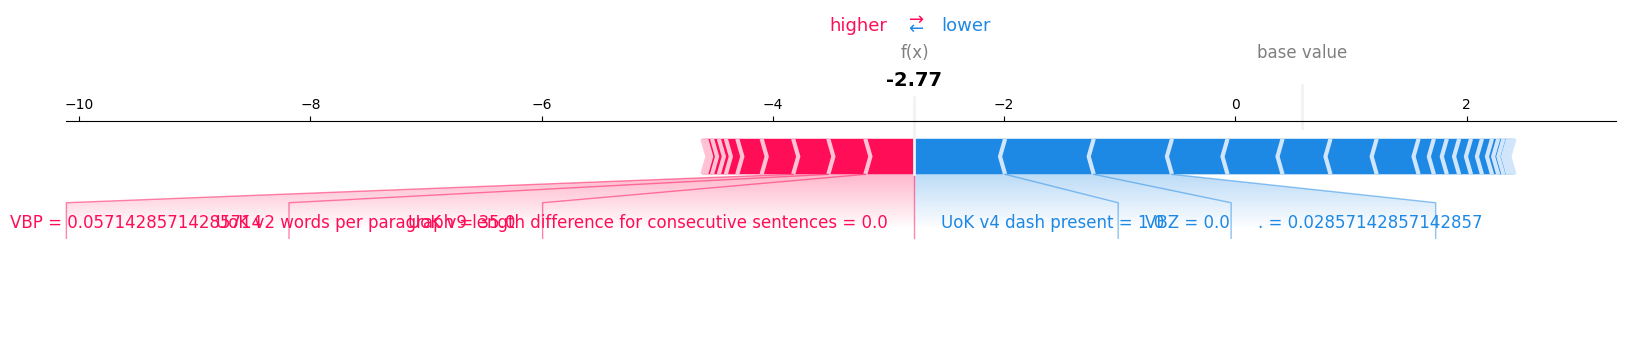

<Figure size 640x480 with 0 Axes>

In [21]:
shap.force_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
)
shap.force_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
    matplotlib=True,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


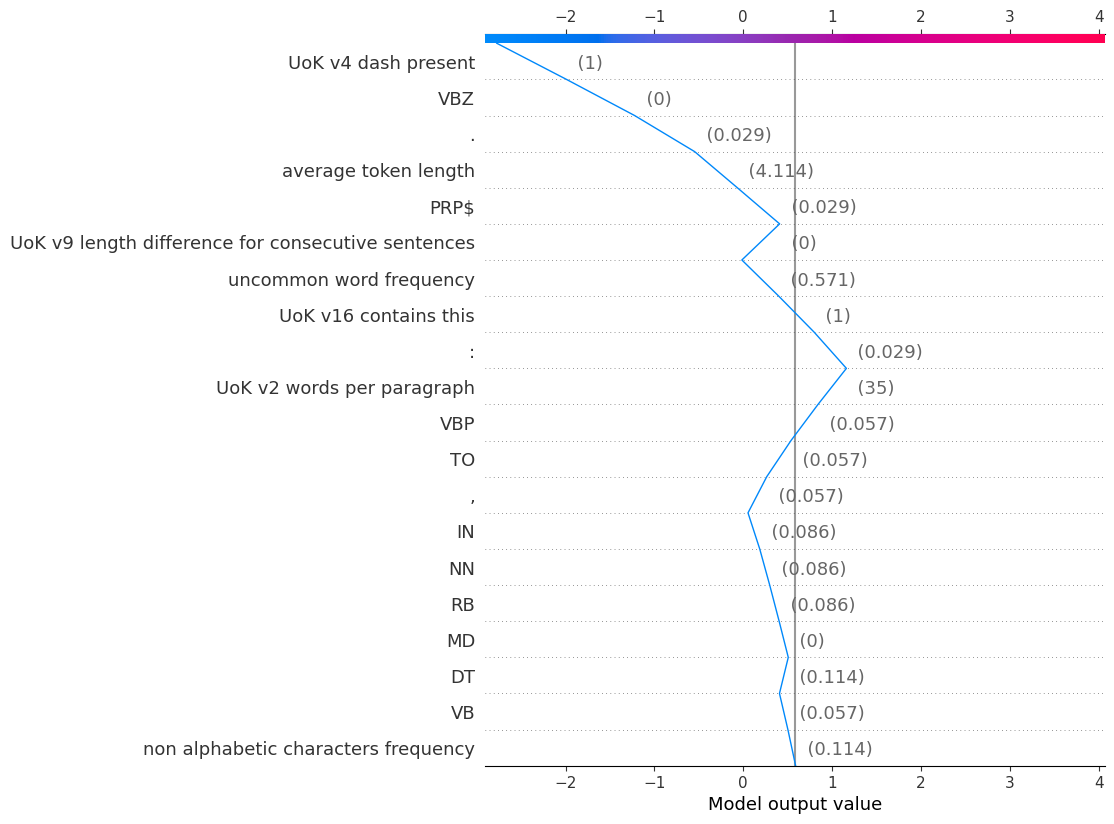

<Figure size 640x480 with 0 Axes>

In [22]:
shap.decision_plot(
    explainer.expected_value[1],  # type: ignore
    test_shap_val[0],
    result.test_data.iloc[0],
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()



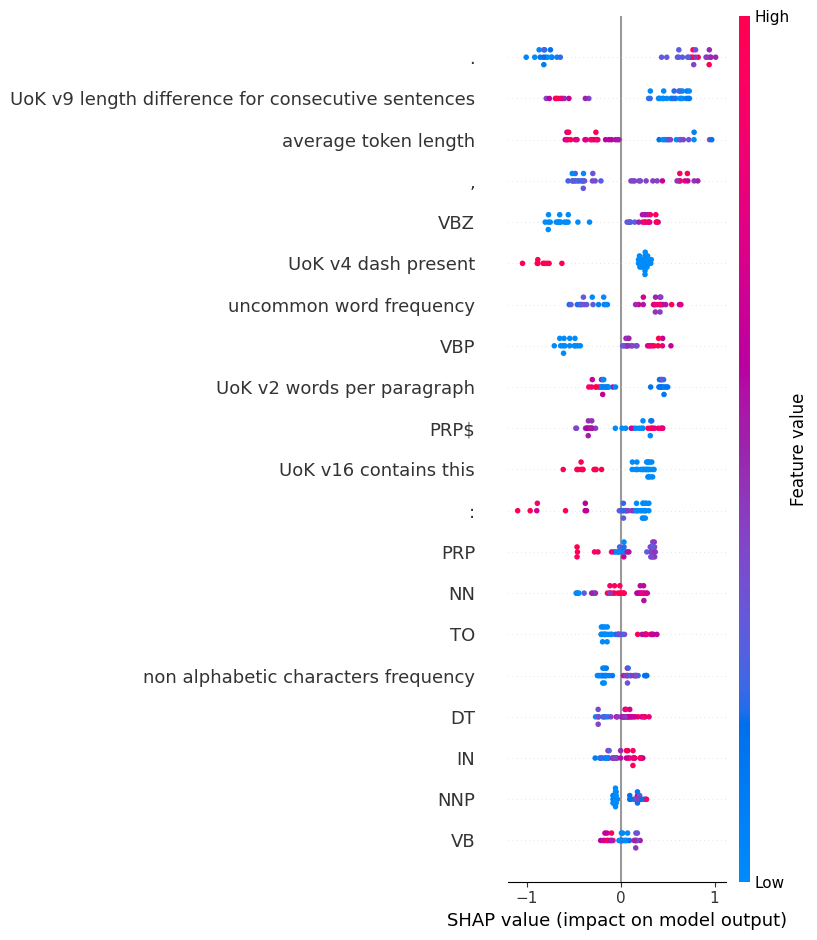

<Figure size 640x480 with 0 Axes>

In [23]:
shap.summary_plot(
    test_shap_val,
    result.test_data,
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


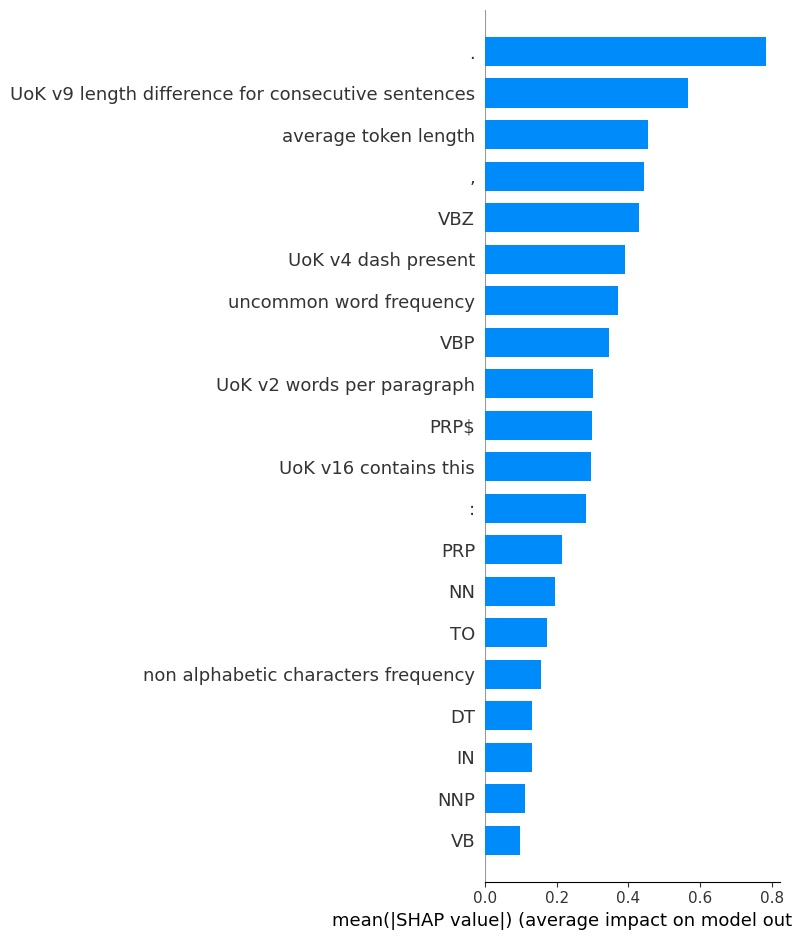

<Figure size 640x480 with 0 Axes>

In [24]:
shap.summary_plot(
    test_shap_val,
    result.test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    PathUtil.SHAP_FIGURE_DIR.joinpath("inaugural", "shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()
